# Differentiate players between teams

## Before you start

Let's make sure that we have access to GPU. We can use `nvidia-smi` command to do that.

In [1]:
from ai.config import PROJ_ROOT
!nvidia-smi

2025-01-15 02:31:08.981 | INFO     | ai.config:<module>:11 - PROJ_ROOT path is: /home/dominika/Desktop/24Z_sem5/ZPRP/project/football-analytics


Wed Jan 15 02:31:09 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 565.77                 Driver Version: 565.77         CUDA Version: 12.7     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce RTX 3060 ...    Off |   00000000:01:00.0  On |                  N/A |
| N/A   40C    P5             15W /   85W |     223MiB /   6144MiB |     12%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

## Install dependencies


Let's install the `inference-gpu` library, which will be used to efficiently run our object detection and keypoint detection models on GPUs. `inference-gpu` utilizes the `onnxruntime-gpu` library internally for optimal performance. We'll install a specific version of `onnxruntime-gpu` to guarantee compatibility with the CUDA 12.

In [2]:
# !python -m pip install -q gdown inference-gpu
# !python -m pip install -q onnxruntime-gpu==1.18.0 --index-url https://aiinfra.pkgs.visualstudio.com/PublicPackages/_packaging/onnxruntime-cuda-12/pypi/simple/

Let's install PyTorch library, but make sure you're installing version compatible with your environment: https://pytorch.org/get-started/locally/

In [3]:
!python -m pip install torch torchvision torchaudio

Let's install ultralytics library.

In [4]:
!python -m pip install ultralytics

Let's make sure we have the latest features in the supervision library by installing version `0.23.0` or higher.

In [5]:
!python -m pip install supervision==0.23.0

Let's install transformers and sentencepiece libraries.

In [6]:
!python -m pip install 'transformers[torch]'
!python -m pip install sentencepiece

Let's install numpy and more-itertools libraries.

In [7]:
!python -m pip install numpy
!python -m pip install more-itertools

Let's install scikit-learn and umap-learn libraries.

In [8]:
!python -m pip install -U scikit-learn
!python -m pip install umap-learn

## Load player detection model

In [9]:
import os
import torch
from pathlib import Path
from ultralytics import YOLO


NOTEBOOK_PATH = Path(os.getcwd())

DEVICE = "cpu"
if torch.cuda.is_available():
    DEVICE = "cuda"
elif torch.mps.is_available():
    DEVICE = "mps"

PLAYER_DETECTION_MODEL_PATH = "../models/player_inference.pt"
PLAYER_DETECTION_MODEL = YOLO(PLAYER_DETECTION_MODEL_PATH).to(DEVICE)

## Split players into teams

### Gathering training data

To gather training data, we'll sample one frame per second, detect players within those frames, and then crop them out.

In [10]:
import supervision as sv
from tqdm import tqdm


PLAYER_ID = 1
STRIDE = 30

def extract_crops(source_video_path: str) -> list:
    frame_generator = sv.get_video_frames_generator(source_path=source_video_path, stride=STRIDE)

    crops = []

    for frame in tqdm(frame_generator, desc="collecting crops"):
        result = PLAYER_DETECTION_MODEL.predict(frame, conf=0.3)[0]

        detections = sv.Detections.from_ultralytics(result)
        detections = detections.with_nms(threshold=0.5, class_agnostic=True)
        detections = detections[detections.class_id == PLAYER_ID]

        players_crops = [sv.crop_image(frame, xyxy) for xyxy in detections.xyxy]
        crops += players_crops

    return crops

In [11]:
SOURCE_VIDEO_PATH = "../data/test.mp4"
crops = extract_crops(SOURCE_VIDEO_PATH)

collecting crops: 0it [00:00, ?it/s]


0: 736x1280 22 players, 3 referees, 94.4ms
Speed: 7.8ms preprocess, 94.4ms inference, 103.8ms postprocess per image at shape (1, 3, 736, 1280)


collecting crops: 1it [00:02,  2.52s/it]


0: 736x1280 20 players, 3 referees, 80.6ms
Speed: 9.4ms preprocess, 80.6ms inference, 1.1ms postprocess per image at shape (1, 3, 736, 1280)


collecting crops: 2it [00:02,  1.11s/it]


0: 736x1280 1 goalkeeper, 21 players, 3 referees, 86.9ms
Speed: 12.8ms preprocess, 86.9ms inference, 1.0ms postprocess per image at shape (1, 3, 736, 1280)


collecting crops: 3it [00:02,  1.52it/s]


0: 736x1280 21 players, 3 referees, 87.3ms
Speed: 11.4ms preprocess, 87.3ms inference, 1.1ms postprocess per image at shape (1, 3, 736, 1280)


collecting crops: 4it [00:02,  2.25it/s]


0: 736x1280 21 players, 3 referees, 87.5ms
Speed: 9.5ms preprocess, 87.5ms inference, 1.0ms postprocess per image at shape (1, 3, 736, 1280)


collecting crops: 5it [00:02,  3.06it/s]


0: 736x1280 1 goalkeeper, 23 players, 3 referees, 88.5ms
Speed: 10.5ms preprocess, 88.5ms inference, 1.1ms postprocess per image at shape (1, 3, 736, 1280)


collecting crops: 6it [00:03,  3.90it/s]


0: 736x1280 1 goalkeeper, 20 players, 3 referees, 87.7ms
Speed: 9.1ms preprocess, 87.7ms inference, 1.1ms postprocess per image at shape (1, 3, 736, 1280)


collecting crops: 7it [00:03,  4.74it/s]


0: 736x1280 1 goalkeeper, 19 players, 3 referees, 89.6ms
Speed: 9.9ms preprocess, 89.6ms inference, 1.1ms postprocess per image at shape (1, 3, 736, 1280)


collecting crops: 8it [00:03,  5.51it/s]


0: 736x1280 1 goalkeeper, 20 players, 3 referees, 88.2ms
Speed: 8.7ms preprocess, 88.2ms inference, 1.1ms postprocess per image at shape (1, 3, 736, 1280)


collecting crops: 9it [00:03,  6.20it/s]


0: 736x1280 2 goalkeepers, 19 players, 2 referees, 87.6ms
Speed: 10.1ms preprocess, 87.6ms inference, 1.0ms postprocess per image at shape (1, 3, 736, 1280)


collecting crops: 10it [00:03,  6.79it/s]


0: 736x1280 1 goalkeeper, 21 players, 3 referees, 88.3ms
Speed: 8.5ms preprocess, 88.3ms inference, 1.1ms postprocess per image at shape (1, 3, 736, 1280)


collecting crops: 11it [00:03,  7.12it/s]


0: 736x1280 1 goalkeeper, 21 players, 3 referees, 85.0ms
Speed: 11.3ms preprocess, 85.0ms inference, 2.3ms postprocess per image at shape (1, 3, 736, 1280)


collecting crops: 12it [00:03,  7.52it/s]


0: 736x1280 2 goalkeepers, 20 players, 3 referees, 88.0ms
Speed: 9.2ms preprocess, 88.0ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)


collecting crops: 13it [00:03,  7.80it/s]


0: 736x1280 1 goalkeeper, 20 players, 3 referees, 88.2ms
Speed: 8.5ms preprocess, 88.2ms inference, 1.3ms postprocess per image at shape (1, 3, 736, 1280)


collecting crops: 14it [00:04,  8.03it/s]


0: 736x1280 1 goalkeeper, 20 players, 3 referees, 83.6ms
Speed: 9.5ms preprocess, 83.6ms inference, 1.1ms postprocess per image at shape (1, 3, 736, 1280)


collecting crops: 15it [00:04,  8.27it/s]


0: 736x1280 1 goalkeeper, 21 players, 3 referees, 86.8ms
Speed: 12.5ms preprocess, 86.8ms inference, 1.1ms postprocess per image at shape (1, 3, 736, 1280)


collecting crops: 16it [00:04,  8.32it/s]


0: 736x1280 1 goalkeeper, 20 players, 2 referees, 87.2ms
Speed: 9.3ms preprocess, 87.2ms inference, 1.1ms postprocess per image at shape (1, 3, 736, 1280)


collecting crops: 17it [00:04,  8.44it/s]


0: 736x1280 1 goalkeeper, 18 players, 2 referees, 87.4ms
Speed: 9.7ms preprocess, 87.4ms inference, 1.1ms postprocess per image at shape (1, 3, 736, 1280)


collecting crops: 18it [00:04,  8.47it/s]


0: 736x1280 21 players, 2 referees, 88.5ms
Speed: 12.3ms preprocess, 88.5ms inference, 1.1ms postprocess per image at shape (1, 3, 736, 1280)


collecting crops: 19it [00:04,  8.41it/s]


0: 736x1280 19 players, 3 referees, 88.4ms
Speed: 9.3ms preprocess, 88.4ms inference, 1.1ms postprocess per image at shape (1, 3, 736, 1280)


collecting crops: 20it [00:04,  8.46it/s]


0: 736x1280 19 players, 2 referees, 88.7ms
Speed: 8.7ms preprocess, 88.7ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)


collecting crops: 21it [00:04,  8.49it/s]


0: 736x1280 18 players, 5 referees, 88.3ms
Speed: 11.1ms preprocess, 88.3ms inference, 1.0ms postprocess per image at shape (1, 3, 736, 1280)


collecting crops: 22it [00:04,  8.47it/s]


0: 736x1280 1 goalkeeper, 17 players, 4 referees, 88.8ms
Speed: 9.2ms preprocess, 88.8ms inference, 1.1ms postprocess per image at shape (1, 3, 736, 1280)


collecting crops: 23it [00:05,  8.49it/s]


0: 736x1280 19 players, 4 referees, 88.5ms
Speed: 9.0ms preprocess, 88.5ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)


collecting crops: 24it [00:05,  8.52it/s]


0: 736x1280 19 players, 4 referees, 89.5ms
Speed: 9.0ms preprocess, 89.5ms inference, 1.1ms postprocess per image at shape (1, 3, 736, 1280)


collecting crops: 25it [00:05,  4.67it/s]


In [12]:
len(crops)

487

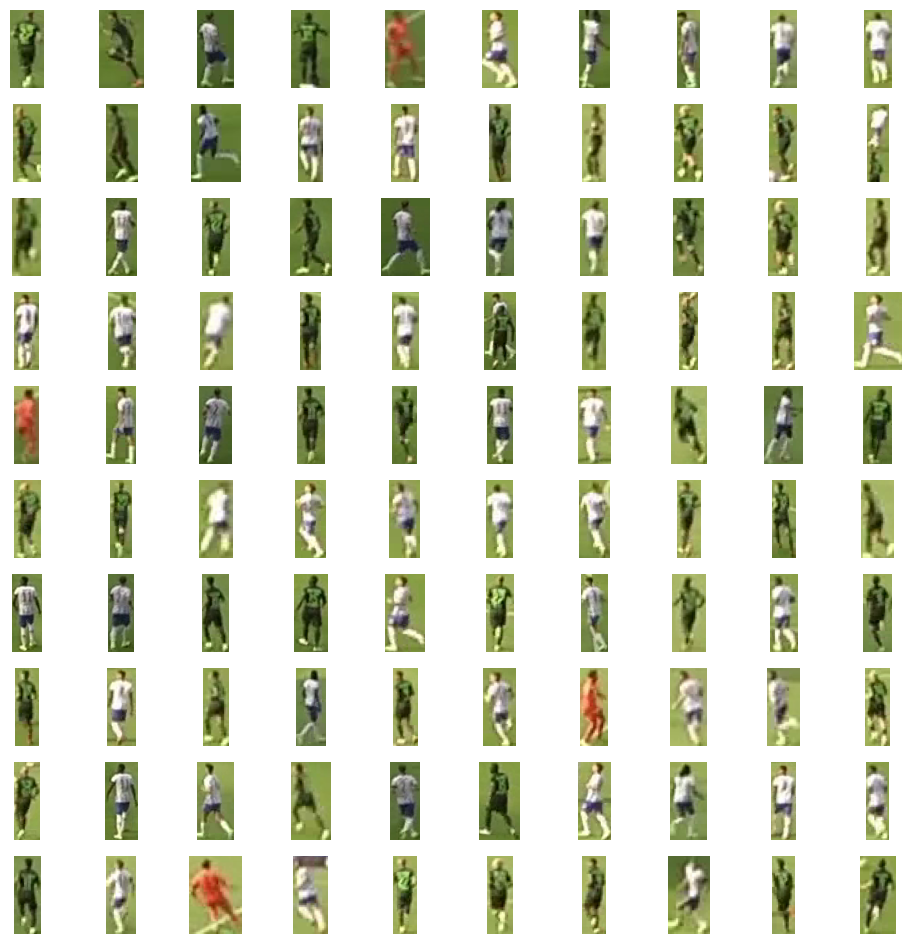

In [13]:
sv.plot_images_grid(crops[:100], grid_size=(10, 10))

### Calculating embeddings for each of the crops using SigLip

Let's load SigLip model first.

In [14]:
from transformers import AutoProcessor, SiglipVisionModel


def load_siglip_model():
    SIGLIP_MODEL_PATH = 'google/siglip-base-patch16-224'

    EMBEDDINGS_MODEL = SiglipVisionModel.from_pretrained(SIGLIP_MODEL_PATH).to(DEVICE)
    EMBEDDINGS_PROCESSOR = AutoProcessor.from_pretrained(SIGLIP_MODEL_PATH)

    return EMBEDDINGS_MODEL, EMBEDDINGS_PROCESSOR

In [15]:
EMBEDDINGS_MODEL, EMBEDDINGS_PROCESSOR = load_siglip_model()

Let's run SigLip model on crops.

In [16]:
import numpy as np
from more_itertools import chunked

BATCH_SIZE = 32

def extract_features(crops: list, embedding_model, embedding_processor) -> np.ndarray:
    crops = [sv.cv2_to_pillow(crop) for crop in crops]
    batches = chunked(crops, BATCH_SIZE)
    data = []
    with torch.no_grad():
        for batch in tqdm(batches, desc='embedding extraction'):
            inputs = embedding_processor(images=batch, return_tensors="pt").to(DEVICE)
            outputs = embedding_model(**inputs)

            embeddings = torch.mean(outputs.last_hidden_state, dim=1).cpu().numpy()
            data.append(embeddings)

    data = np.concatenate(data)
    return data

In [17]:
data = extract_features(crops, EMBEDDINGS_MODEL, EMBEDDINGS_PROCESSOR)

embedding extraction: 16it [00:04,  3.57it/s]


In [18]:
data.shape

(487, 768)

### Projecting our embeddings from (N, 768) to (N, 3) using UMAP and performing a two-cluster division using KMeans

In [19]:
import umap
from sklearn.cluster import KMeans


REDUCER = umap.UMAP(n_components=3)
CLUSTERING_MODEL = KMeans(n_clusters=2)

projections = REDUCER.fit_transform(data)
clusters = CLUSTERING_MODEL.fit_predict(projections)

In [20]:
projections.shape

(487, 3)

In [21]:
clusters[:10]

array([0, 0, 1, 0, 0, 1, 1, 1, 1, 1], dtype=int32)

In [22]:
team_0 = [
    crop
    for crop, cluster
    in zip(crops, clusters)
    if cluster == 0
]

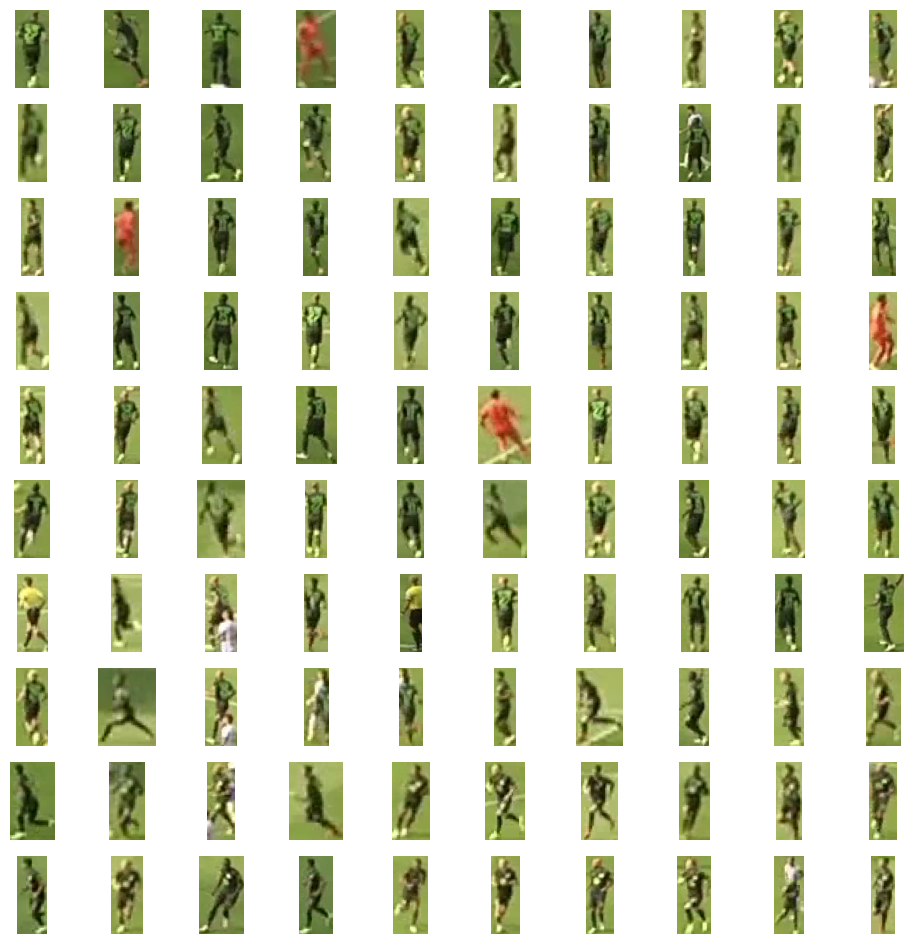

In [23]:
sv.plot_images_grid(team_0[:100], grid_size=(10, 10))

### Assigning goalkeepers to teams

In [24]:
import numpy as np
import supervision as sv

def resolve_goalkeepers_team_id(players: sv.Detections, goalkeepers: sv.Detections) -> np.ndarray:
    goalkeepers_xy = goalkeepers.get_anchors_coordinates(sv.Position.BOTTOM_CENTER)
    players_xy = players.get_anchors_coordinates(sv.Position.BOTTOM_CENTER)

    team_0_centroid = players_xy[players.class_id == 0].mean(axis=0)
    team_1_centroid = players_xy[players.class_id == 1].mean(axis=0)

    goalkeepers_team_id = []

    for goalkeeper_xy in goalkeepers_xy:
        dist_0 = np.linalg.norm(goalkeeper_xy - team_0_centroid)
        dist_1 = np.linalg.norm(goalkeeper_xy - team_1_centroid)

        goalkeepers_team_id.append(0 if dist_0 < dist_1 else 1)

    return np.array(goalkeepers_team_id)

## Show results

In [25]:
crops = extract_crops(SOURCE_VIDEO_PATH)

# Fit
EMBEDDINGS_MODEL, EMBEDDINGS_PROCESSOR = load_siglip_model()
data = extract_features(crops, EMBEDDINGS_MODEL, EMBEDDINGS_PROCESSOR)

REDUCER = umap.UMAP(n_components=3)
CLUSTERING_MODEL = KMeans(n_clusters=2)

projections = REDUCER.fit_transform(data)
CLUSTERING_MODEL.fit(projections)

collecting crops: 0it [00:00, ?it/s]


0: 736x1280 22 players, 3 referees, 100.1ms
Speed: 8.1ms preprocess, 100.1ms inference, 1.1ms postprocess per image at shape (1, 3, 736, 1280)


collecting crops: 1it [00:00,  5.73it/s]


0: 736x1280 20 players, 3 referees, 97.3ms
Speed: 9.7ms preprocess, 97.3ms inference, 1.1ms postprocess per image at shape (1, 3, 736, 1280)


collecting crops: 2it [00:00,  6.56it/s]


0: 736x1280 1 goalkeeper, 21 players, 3 referees, 89.2ms
Speed: 10.5ms preprocess, 89.2ms inference, 1.1ms postprocess per image at shape (1, 3, 736, 1280)


collecting crops: 3it [00:00,  7.31it/s]


0: 736x1280 21 players, 3 referees, 88.6ms
Speed: 10.4ms preprocess, 88.6ms inference, 1.3ms postprocess per image at shape (1, 3, 736, 1280)


collecting crops: 4it [00:00,  7.73it/s]


0: 736x1280 21 players, 3 referees, 89.3ms
Speed: 9.1ms preprocess, 89.3ms inference, 1.1ms postprocess per image at shape (1, 3, 736, 1280)


collecting crops: 5it [00:00,  7.96it/s]


0: 736x1280 1 goalkeeper, 23 players, 3 referees, 87.3ms
Speed: 9.8ms preprocess, 87.3ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)


collecting crops: 6it [00:00,  8.15it/s]


0: 736x1280 1 goalkeeper, 20 players, 3 referees, 90.1ms
Speed: 7.5ms preprocess, 90.1ms inference, 1.1ms postprocess per image at shape (1, 3, 736, 1280)


collecting crops: 7it [00:00,  8.25it/s]


0: 736x1280 1 goalkeeper, 19 players, 3 referees, 89.4ms
Speed: 10.6ms preprocess, 89.4ms inference, 1.1ms postprocess per image at shape (1, 3, 736, 1280)


collecting crops: 8it [00:01,  8.30it/s]


0: 736x1280 1 goalkeeper, 20 players, 3 referees, 85.4ms
Speed: 8.3ms preprocess, 85.4ms inference, 1.1ms postprocess per image at shape (1, 3, 736, 1280)


collecting crops: 9it [00:01,  8.45it/s]


0: 736x1280 2 goalkeepers, 19 players, 2 referees, 85.9ms
Speed: 8.9ms preprocess, 85.9ms inference, 1.1ms postprocess per image at shape (1, 3, 736, 1280)


collecting crops: 10it [00:01,  8.55it/s]


0: 736x1280 1 goalkeeper, 21 players, 3 referees, 88.3ms
Speed: 9.5ms preprocess, 88.3ms inference, 1.1ms postprocess per image at shape (1, 3, 736, 1280)


collecting crops: 11it [00:01,  8.52it/s]


0: 736x1280 1 goalkeeper, 21 players, 3 referees, 87.0ms
Speed: 10.4ms preprocess, 87.0ms inference, 1.1ms postprocess per image at shape (1, 3, 736, 1280)


collecting crops: 12it [00:01,  8.52it/s]


0: 736x1280 2 goalkeepers, 20 players, 3 referees, 85.6ms
Speed: 9.8ms preprocess, 85.6ms inference, 1.1ms postprocess per image at shape (1, 3, 736, 1280)


collecting crops: 13it [00:01,  8.59it/s]


0: 736x1280 1 goalkeeper, 20 players, 3 referees, 87.1ms
Speed: 10.4ms preprocess, 87.1ms inference, 1.1ms postprocess per image at shape (1, 3, 736, 1280)


collecting crops: 14it [00:01,  8.59it/s]


0: 736x1280 1 goalkeeper, 20 players, 3 referees, 88.4ms
Speed: 7.5ms preprocess, 88.4ms inference, 1.1ms postprocess per image at shape (1, 3, 736, 1280)


collecting crops: 15it [00:01,  8.62it/s]


0: 736x1280 1 goalkeeper, 21 players, 3 referees, 88.6ms
Speed: 7.7ms preprocess, 88.6ms inference, 1.1ms postprocess per image at shape (1, 3, 736, 1280)


collecting crops: 16it [00:01,  8.61it/s]


0: 736x1280 1 goalkeeper, 20 players, 2 referees, 83.1ms
Speed: 7.9ms preprocess, 83.1ms inference, 1.1ms postprocess per image at shape (1, 3, 736, 1280)


collecting crops: 17it [00:02,  8.72it/s]


0: 736x1280 1 goalkeeper, 18 players, 2 referees, 87.8ms
Speed: 7.1ms preprocess, 87.8ms inference, 1.1ms postprocess per image at shape (1, 3, 736, 1280)


collecting crops: 18it [00:02,  8.66it/s]


0: 736x1280 21 players, 2 referees, 88.3ms
Speed: 7.6ms preprocess, 88.3ms inference, 2.3ms postprocess per image at shape (1, 3, 736, 1280)


collecting crops: 19it [00:02,  8.57it/s]


0: 736x1280 19 players, 3 referees, 90.3ms
Speed: 7.1ms preprocess, 90.3ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)


collecting crops: 20it [00:02,  8.51it/s]


0: 736x1280 19 players, 2 referees, 88.8ms
Speed: 8.5ms preprocess, 88.8ms inference, 2.2ms postprocess per image at shape (1, 3, 736, 1280)


collecting crops: 21it [00:02,  8.43it/s]


0: 736x1280 18 players, 5 referees, 88.6ms
Speed: 7.4ms preprocess, 88.6ms inference, 1.1ms postprocess per image at shape (1, 3, 736, 1280)


collecting crops: 22it [00:02,  8.44it/s]


0: 736x1280 1 goalkeeper, 17 players, 4 referees, 92.3ms
Speed: 7.1ms preprocess, 92.3ms inference, 1.1ms postprocess per image at shape (1, 3, 736, 1280)


collecting crops: 23it [00:02,  8.40it/s]


0: 736x1280 19 players, 4 referees, 90.6ms
Speed: 8.2ms preprocess, 90.6ms inference, 2.3ms postprocess per image at shape (1, 3, 736, 1280)


collecting crops: 24it [00:02,  8.35it/s]


0: 736x1280 19 players, 4 referees, 88.6ms
Speed: 7.0ms preprocess, 88.6ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)


collecting crops: 25it [00:03,  8.27it/s]
embedding extraction: 16it [00:04,  3.50it/s]


KMeans(n_clusters=2)


0: 736x1280 22 players, 3 referees, 140.9ms
Speed: 8.5ms preprocess, 140.9ms inference, 2.2ms postprocess per image at shape (1, 3, 736, 1280)


embedding extraction: 1it [00:00,  1.78it/s]


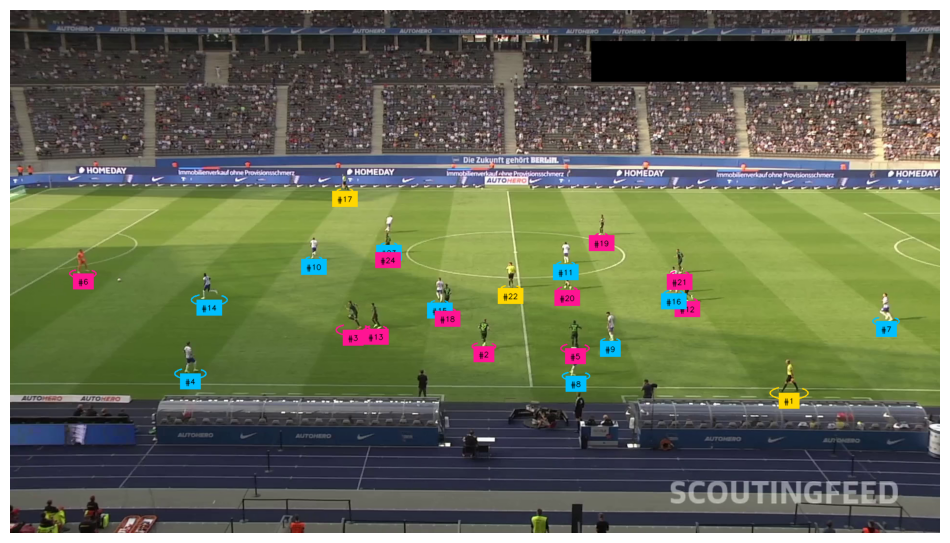

In [45]:
import supervision as sv

SOURCE_VIDEO_PATH = "../data/test.mp4"
GOALKEEPER_ID = 0
PLAYER_ID = 1
REFEREE_ID = 2

ellipse_annotator = sv.EllipseAnnotator(
    color=sv.ColorPalette.from_hex(['#00BFFF', '#FF1493', '#FFD700']),
    thickness=2
)

label_annotator = sv.LabelAnnotator(
    color=sv.ColorPalette.from_hex(['#00BFFF', '#FF1493', '#FFD700']),
    text_color=sv.Color.from_hex('#000000'),
    text_position=sv.Position.BOTTOM_CENTER
)

tracker = sv.ByteTrack()
tracker.reset()

frame_generator = sv.get_video_frames_generator(SOURCE_VIDEO_PATH)
frame = next(frame_generator)

result = PLAYER_DETECTION_MODEL.predict(frame, conf=0.3)[0]
detections = sv.Detections.from_ultralytics(result)

all_detections = detections.with_nms(threshold=0.5, class_agnostic=True)
all_detections = tracker.update_with_detections(detections=all_detections)

goalkeepers_detections = all_detections[all_detections.class_id == GOALKEEPER_ID]
players_detections = all_detections[all_detections.class_id == PLAYER_ID]
referees_detections = all_detections[all_detections.class_id == REFEREE_ID]

players_crops = [sv.crop_image(frame, xyxy) for xyxy in players_detections.xyxy]

# Predict
data = extract_features(players_crops, EMBEDDINGS_MODEL, EMBEDDINGS_PROCESSOR)
projections = REDUCER.transform(data)
players_detections.class_id = CLUSTERING_MODEL.predict(projections)

goalkeepers_detections.class_id = resolve_goalkeepers_team_id(players_detections, goalkeepers_detections)

all_detections = sv.Detections.merge([players_detections, goalkeepers_detections, referees_detections])

labels = [
    f"#{tracker_id}"
    for tracker_id
    in all_detections.tracker_id
]

all_detections.class_id = all_detections.class_id.astype(int)

annotated_frame = frame.copy()

annotated_frame = ellipse_annotator.annotate(
    scene=annotated_frame,
    detections=all_detections)

annotated_frame = label_annotator.annotate(
    scene=annotated_frame,
    detections=all_detections,
    labels=labels)

sv.plot_image(annotated_frame)